# Day-Averaged Yearly Profiles clustering

In [1]:
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta

logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
outlier = pl.read_csv(r'C:\Users\pana\Desktop\DATA\ckw\outliers.csv')
outlier =outlier.to_numpy()
print("no of outliers are ",len(outlier))

no of outliers are  1657


## Loading files
each individual file should contain day-averaged energy consumption data from 1st March 2021 to 28th Feb 2022. For other time periods modify the timestamp

In [3]:
timestamp_range= pl.datetime_range(datetime(2021,2,28), datetime(2022,3,1), "1d",eager=True)

In [4]:
# Function to extract numeric part from file name
season = "daily"

def extract_numeric_part(file_path):
    match = re.search(rf'(\d+)_{season}_data\.csv', file_path)
    if match:
        return int(match.group(1))
    else:
        print(f"Warning: Filename {file_path} does not match pattern")
        return None

# Get the list of file paths
file_paths = glob.glob(rf'C:\Users\pana\Desktop\DATA\ckw\2021\{season}\*_{season}_data.csv')
file_paths = sorted(file_paths, key=extract_numeric_part)

file_paths = [file_paths[i] for i in range(len(file_paths)) if i not in outlier]
file_paths = [file_paths[i] for i in range(5000) if i not in outlier]
print("number of datasets remaining", len(file_paths))

number of datasets remaining 4968


In [5]:
value = 'normalized_kwh' #or mean_kwh

def load_and_preprocess_savefile(file_paths, timestamp_range, output_csv_file):
    # Number of timestamps per time series
    n_timestamps = len(timestamp_range)
    
    # Initialize an empty list to store data temporarily
    data_list = []
    successful_files = []  # To store filenames of successfully processed files
    
    for idx, file_path in enumerate(file_paths):
        try:
            # Read the CSV file
            df = pl.read_csv(file_path)
            
            # Ensure that the data has the correct number of timestamps
            if len(df) == n_timestamps:
                # Extract values directly
                values_array = df[value].to_numpy().reshape((1, n_timestamps))
                
                # Append the reshaped array to the list
                data_list.append(values_array)
                                # Extract just the file number (e.g., 0 from 'DATA/daily/0_daily_data.csv')
                file_number = os.path.basename(file_path).split('_')[0]
                successful_files.append(file_number)
            
            if idx % 5000 == 0:
                print(idx, "done")
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue
    
    # Convert list to a single 3D numpy array
    if data_list:
        data_3d = np.concatenate(data_list, axis=0)
        
        print(f"Shape of the 3D array: {data_3d.shape}")
        
        # Save the list of successful file numbers to a CSV
        successful_files_df = pl.DataFrame({
            'house_no': successful_files
        })
        successful_files_df.write_csv(output_csv_file)
        print(f"File numbers of successful files written to {output_csv_file}")
    
    else:
        print("No valid data to write.")
    
    return successful_files

output_csv_file = "day_averaged_files.csv" #this csv file contains the house numbers included for the clustering

# Call the function
successful_files = load_and_preprocess_savefile(file_paths, timestamp_range, output_csv_file)

0 done
Shape of the 3D array: (9, 367)
File numbers of successful files written to day_averaged_files.csv


In [6]:
value = 'normalized_kwh'  #normalized_kwh or mean_kwh
def load_and_preprocess(file_paths, timestamp_range):
    # Number of timestamps per time series
    n_timestamps = len(timestamp_range)
    
    # Determine the number of files to load
    num_files = len(file_paths)
    
    # Initialize an empty list to store data temporarily
    data_list = []
    
    for idx,file_path in enumerate(file_paths):
        # Read the CSV file
        df = pl.read_csv(
        file_path #, dtypes={value: pl.Float64}, truncate_ragged_lines=True,ignore_errors=True
        )
        
        # Ensure that the data has the correct number of timestamps
        if len(df) == n_timestamps:
            # Extract values directly and reshape for 3D format
            values_array = df[value].to_numpy().reshape((1, n_timestamps, 1))
            # Append the reshaped array to the list
            data_list.append(values_array)
        if idx%5000 ==0:
            print(idx,"done")
    
    # Convert list to a single 3D numpy array
    #print(data_list)
    data_3d = np.concatenate(data_list, axis=0)

    print(f"Shape of the 3D array: {data_3d.shape}")
    return data_3d

In [7]:
from tslearn.clustering import TimeSeriesKMeans 

train_data = load_and_preprocess(file_paths,timestamp_range)

n_clusters = 3  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

0 done
Shape of the 3D array: (9, 367, 1)
3.129 --> 2.151 --> 2.151 --> 


In [8]:
#Saving the cluster_indices

# Initialize an empty list to store individual DataFrames for each cluster
cluster_dataframes = []

for cluster_idx in range(n_clusters):
    # Get all indices in this cluster
    cluster_indices = np.where(clusters_train == cluster_idx)[0]
    
    # Create a Polars DataFrame for the current cluster's indices
    cluster_df = pl.DataFrame({
        "cluster": pl.Series([cluster_idx + 1] * len(cluster_indices)),
        "index": pl.Series(cluster_indices)
    })
    
    # Append this cluster DataFrame to the list
    cluster_dataframes.append(cluster_df)

# Concatenate all cluster DataFrames into one
cluster_indices_df = pl.concat(cluster_dataframes)

# Check if 13921(outlier) is in the 'index' column
number_to_check = 13921
exists = cluster_indices_df['index'].is_in([number_to_check]).any()

# Print the DataFrame to verify
print("\nCluster Indices DataFrame:")
print(cluster_indices_df.head())

cluster_indices_df.write_csv(rf'C:\DATA\{season}_avg_{n_clusters}_indices.csv')


Cluster Indices DataFrame:
shape: (5, 2)
┌─────────┬───────┐
│ cluster ┆ index │
│ ---     ┆ ---   │
│ i64     ┆ i64   │
╞═════════╪═══════╡
│ 1       ┆ 1     │
│ 1       ┆ 2     │
│ 1       ┆ 3     │
│ 1       ┆ 4     │
│ 1       ┆ 5     │
└─────────┴───────┘


FileNotFoundError: The system cannot find the path specified. (os error 3)

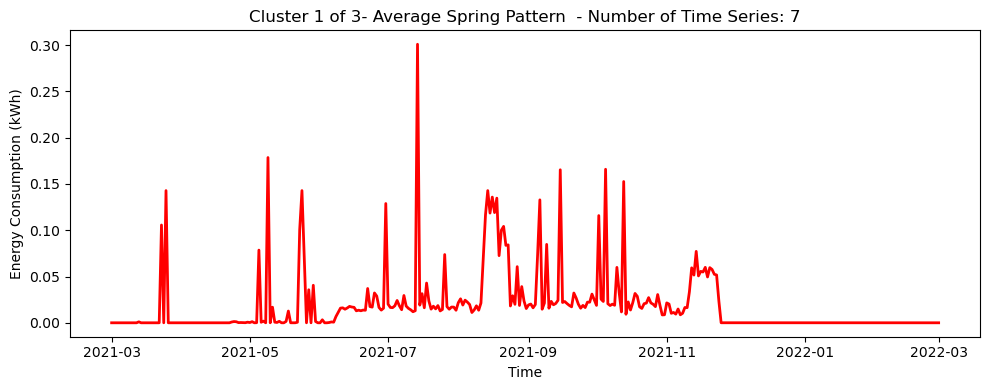

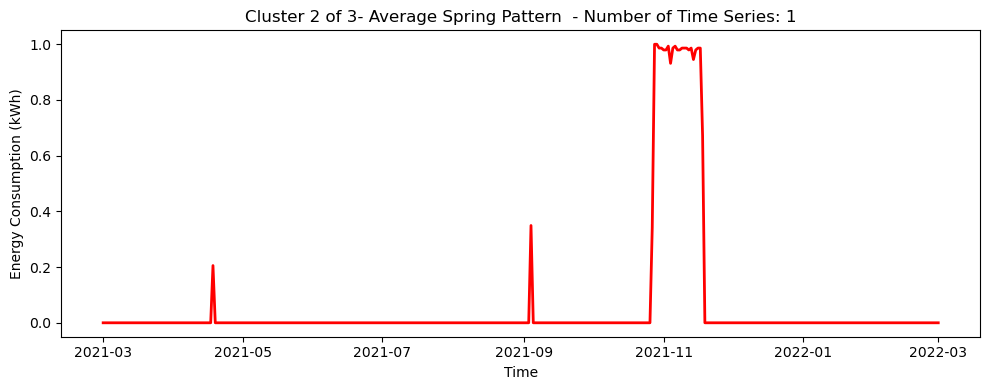

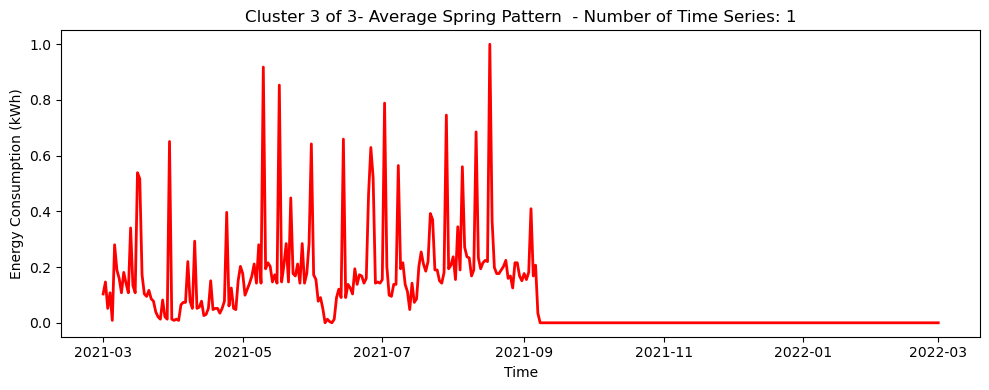

In [9]:
save = 0 #if you want to save the plots save = 1 and add path
plot_range = pl.datetime_range(datetime(2021,3,1), datetime(2022,3,1), "1d",eager=True)
for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    plt.figure(figsize=(10, 4))

    plt.plot(plot_range, mean_time_series.ravel()[1:], linewidth =2, color='red' )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no} of {n_clusters}- Average Spring Pattern  - Number of Time Series: {len(cluster_indices)}")
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh)")
    plt.xticks()
    plt.tight_layout()
    #plt.legend()
    if save==1:
        plot_name=f'{cluster_idx}of4_{season}_avg.png'
        save_path=r'C:\Users\pana\Desktop\plots\without_outliers'
        plt.savefig(os.path.join(save_path,plot_name))
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

# Validation Metric
Default runs Davies-Bouldin, Silhoutte score and Calinski Harabasz scores can be plotted by uncommenting few lines

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
seed_random = 42

fitted_kmeans = {}
labels_kmeans = {}
df_scores = []
k_values_to_try = np.arange(2,26)
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1]))

#fig, ax = plt.subplots(12, 2, figsize=(15,8))
for n_clusters in k_values_to_try:
    
    print(n_clusters)
    #Perform clustering.
    kmeans = KMeans(n_clusters=n_clusters,
                    random_state=seed_random,
                    )
    labels_clusters = kmeans.fit_predict(train_data)
    q, mod = divmod(n_clusters, 2)
    
    #Insert fitted model and calculated cluster labels in dictionaries,
    #for further reference.
    fitted_kmeans[n_clusters] = kmeans
    labels_kmeans[n_clusters] = labels_clusters
    
    #Calculate various scores, and save them for further reference.
    #silhouette = silhouette_score(train_data, labels_clusters)
    #ch = calinski_harabasz_score(train_data, labels_clusters)
    db = davies_bouldin_score(train_data, labels_clusters)
    tmp_scores = {"no_of_clusters": n_clusters,
     #             "silhouette_score": silhouette,
     #             "calinski_harabasz_score": ch,
                  "davies_bouldin_score": db,
                  }
    df_scores.append(tmp_scores)
    
#Create a DataFrame of clustering scores, using `n_clusters` as index, for easier plotting.
df_scores = pl.DataFrame(df_scores)
#df_scores.set_index("no_of_clusters", inplace=True)

plt.figure(figsize=(6, 4))
#plt.plot(df_scores['no_of_clusters'][:25],df_scores['silhouette_score'][:25],label="silhouette_score", marker ='o', color='orange')
plt.plot(df_scores['no_of_clusters'],df_scores['davies_bouldin_score'],label= "Davies_Bouldin_score", marker = 'o', color='black')
#plt.plot(df_scores['no_of_clusters'],df_scores['calinski_harabasz_score'],label= "calinski_harabasz_score", marker = 'o')
plt.title(f"Winter")
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Scores')
#plt.xticks(k_values_to_try)
plt.ylim(1.0,1.95)
plt.legend(loc='upper right') 
plt.grid(False)
#plt.savefig(rf'C:\Desktop\plots\\normalized\Davies_Score_{season}_{days}.png')
plt.show()

# Generalized Additive Model for evaluating impact of temperature on energy consumption

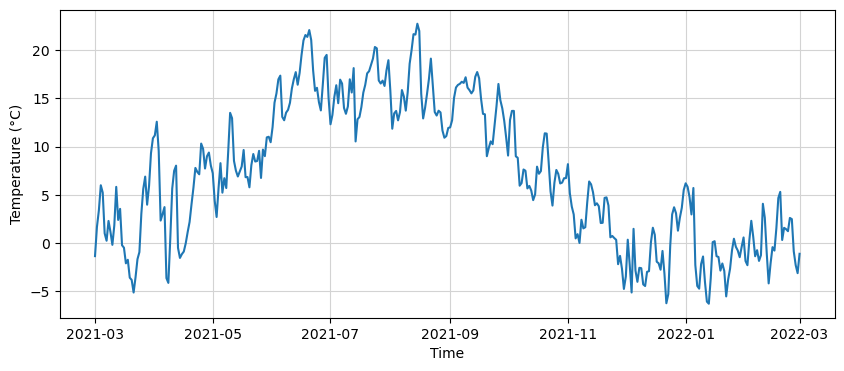

In [18]:
overall_avg_temp = pl.read_csv(r'C:\Users\pana\Desktop\DATA\ckw\temperatures_daily.csv')

plot_range = pl.datetime_range(datetime(2021,3,1), datetime(2022,3,1), "1d",eager=True)
plt.figure(figsize = (10,4))
plt.plot(plot_range, overall_avg_temp['mean_t2m'])
plt.ylabel("Temperature (°C)")
plt.xlabel("Time")
plt.grid(True, color = 'lightgray')
plt.savefig('Temperature_year.png')
plt.show()
overall_avg_temp = overall_avg_temp['mean_t2m']

In [19]:
def extract_cluster_data_polars(energy_data_3d, cluster_indices_df, timestamp_range):

    # Step 2: Initialize dictionaries to store energy sums and counts per cluster
    cluster_sums_energy = {i: np.zeros((366,)) for i in range(1, 5)}  # Assuming clusters 1 to 4
    cluster_counts = {i: 0 for i in range(1, 5)}
    
    # Step 3: Filter cluster indices and accumulate sums for each cluster
    for cluster in range(1, 5):  # Iterate over clusters 1 to 4
        # Get the indices of files for the current cluster
        file_indices = cluster_indices_df.filter(pl.col("cluster") == cluster)['index'].to_list()
        
        # Sum the energy consumption for these files
        for idx in file_indices:
            cluster_sums_energy[cluster] += energy_data_3d[idx].flatten()  # Ensure shape (366,)
            cluster_counts[cluster] += 1
    
    # Step 4: Dictionary to store the resulting DataFrames for each cluster
    cluster_dfs = {}
    
    # Step 5: Compute averages and create DataFrames for each cluster using Polars
    for cluster in range(1, 5):  # Change to range(1, 5) for clusters 1-4
        # Avoid division by zero
        if cluster_counts[cluster] > 0:
            avg_energy = cluster_sums_energy[cluster] / cluster_counts[cluster]
        else:
            avg_energy = np.zeros((366,))
        
        # Create a Polars DataFrame for the cluster (temperature is the same for all clusters)
        cluster_df = pl.DataFrame({
            'date': timestamp_range,                  # Use Polars Series of timestamps directly
            'avg_energy_consumption': avg_energy,     # Average energy per cluster
            'avg_temperature': overall_avg_temp       # Overall temperature (same for all clusters)
        })
        
        # Store the DataFrame in the dictionary
        cluster_dfs[cluster] = cluster_df
    
    return cluster_dfs

timestamp_range= pl.datetime_range(datetime(2021,3,1), datetime(2022,3,1), "1d",eager=True)
energy_data_3d = load_and_preprocess(file_paths,timestamp_range)

# Extract the cluster data using Polars
cluster_dataframes = extract_cluster_data_polars(energy_data_3d, cluster_indices_df, timestamp_range)

# Assign each cluster's DataFrame to a separate variable
cluster_1_df = cluster_dataframes[1]  # Cluster 1
cluster_2_df = cluster_dataframes[2]  # Cluster 2
cluster_3_df = cluster_dataframes[3]  # Cluster 3
cluster_4_df = cluster_dataframes[4]  # Cluster 4

# Optionally, print a few rows to verify
print(cluster_1_df.head())  # First few rows of cluster 1
print(cluster_2_df.head())  # First few rows of cluster 2


0 done
Shape of the 3D array: (4959, 366, 1)
shape: (5, 3)
┌─────────────────────┬────────────────────────┬─────────────────┐
│ date                ┆ avg_energy_consumption ┆ avg_temperature │
│ ---                 ┆ ---                    ┆ ---             │
│ datetime[μs]        ┆ f64                    ┆ f64             │
╞═════════════════════╪════════════════════════╪═════════════════╡
│ 2021-03-01 00:00:00 ┆ 0.513996               ┆ -1.372          │
│ 2021-03-02 00:00:00 ┆ 0.429931               ┆ 1.652333        │
│ 2021-03-03 00:00:00 ┆ 0.454291               ┆ 3.374333        │
│ 2021-03-04 00:00:00 ┆ 0.434824               ┆ 5.981167        │
│ 2021-03-05 00:00:00 ┆ 0.375594               ┆ 5.218333        │
└─────────────────────┴────────────────────────┴─────────────────┘
shape: (5, 3)
┌─────────────────────┬────────────────────────┬─────────────────┐
│ date                ┆ avg_energy_consumption ┆ avg_temperature │
│ ---                 ┆ ---                    ┆ ---    

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def linear_gam_func(daily_df):
    y = daily_df['avg_energy_consumption'].to_numpy()

    if no_of_features == 2:
        X = daily_df[['avg_temperature','month']].to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        linear_gam = LinearGAM(s(0) + s(1)).fit(X_train, y_train)
    else:
        X = daily_df['avg_temperature'].to_numpy().reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        linear_gam = LinearGAM(s(0)).fit(X_train, y_train)

    y_pred = linear_gam.predict(X_test)
    # Mean Squared Error (MSE)
    lgam_mse = mean_squared_error(y_test, y_pred)

    # Root Mean Squared Error (RMSE)
    lgam_rmse = np.sqrt(lgam_mse)

    # Mean Absolute Error (MAE)
    lgam_mae = mean_absolute_error(y_test, y_pred)

    # R-squared (R²)
    lgam_r2 = r2_score(y_test, y_pred)

    print(f"Linear GAM model with {no_of_features} features")
    print(f"Mean Squared Error (MSE): {lgam_mse}")
    print(f"Root Mean Squared Error (RMSE): {lgam_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {lgam_mae:.4f}")
    print(f"R-squared (R²): {lgam_r2:.4f}")

    return linear_gam
# Print the model summary
#print(linear_gam.summary())

In [21]:
from pygam import GAM, s
def gam_func(daily_df):
    y_gam = daily_df['avg_energy_consumption']
    
    if no_of_features ==2:
        X_gam = daily_df[['avg_temperature', 'month']]
        X_train, X_test, y_train, y_test = train_test_split(X_gam, y_gam, test_size=0.2, random_state=42)
        gam = GAM(s(0, lam = 0.9) + s(1)).fit(X_gam, y_gam)
        
    else:
        X_gam = daily_df['avg_temperature']
        X_train, X_test, y_train, y_test = train_test_split(X_gam, y_gam, test_size=0.2, random_state=42)
        gam = GAM(s(0)).fit(X_train, y_train)
    
    y_pred = gam.predict(X_test)
    # Mean Squared Error (MSE)
    gam_mse = mean_squared_error(y_test, y_pred)
    
    # Root Mean Squared Error (RMSE)
    gam_rmse = np.sqrt(gam_mse)
    
    # Mean Absolute Error (MAE)
    gam_mae = mean_absolute_error(y_test, y_pred)
    
    # R-squared (R²)
    gam_r2 = r2_score(y_test, y_pred)
    
    print(f"GAM model with {no_of_features} features")
    print(f"Mean Squared Error (MSE): {gam_mse}")
    print(f"Root Mean Squared Error (RMSE): {gam_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {gam_mae:.4f}")
    print(f"R-squared (R²): {gam_r2:.4f}")

    return gam
# Print the model summary
#print(linear_gam.summary())

In [22]:
def smooth_term(daily_df_pandas,gam):
    # Generate a range of temperature values
    temperature_range = np.linspace(daily_df_pandas['avg_temperature'].min(), daily_df_pandas['avg_temperature'].max(), 100)
    
    # Create a DataFrame for temperature values with a placeholder for month
    temperature_df = pl.DataFrame({
        'avg_temperature': temperature_range,
    #    'month': [daily_df_pandas['month'].mean()] * len(temperature_range)  # Use mean value of month
    })
    
    # Compute partial dependence for the temperature smooth term
    s_temp = gam.partial_dependence(term=0, X=temperature_df.to_pandas())
    
    # Plot s(temperature) vs temperature
    plt.figure(figsize=(6, 4))
    
    #plt.subplot(1, 2, 1)
    plt.plot(temperature_range, s_temp, label='s(Temperature)', color='b')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Temperature')
    plt.ylabel('s(Temperature)')
    plt.title('Smooth Term s(Temperature) vs Temperature')
    plt.legend()
    plt.grid(True, alpha= 0.5, color= 'lightgray')

    return s_temp

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
def LR_func(daily_df):
    #X = daily_df[['avg_temperature','month']].to_numpy()
    X = daily_df['avg_temperature'].to_numpy().reshape(-1,1)
    y = daily_df['avg_energy_consumption'].to_numpy()
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # 20 % of data alloted for testing
    
    # Define and fit the linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = linear_model.predict(X_test)
    
    # Mean Squared Error (MSE)
    lreg_mse = mean_squared_error(y_test, y_pred)
    
    # Root Mean Squared Error (RMSE)
    lreg_rmse = np.sqrt(lreg_mse)
    
    # Mean Absolute Error (MAE)
    lreg_mae = mean_absolute_error(y_test, y_pred)
    
    # R-squared (R²)
    lreg_r2 = r2_score(y_test, y_pred)
    
    print("Linear Regression Model")
    print(f"Mean Squared Error (MSE): {lreg_mse}")
    print(f"Root Mean Squared Error (RMSE): {lreg_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {lreg_mae:.4f}")
    print(f"R-squared (R²): {lreg_r2:.4f}")

    return linear_model

Linear Regression Model
Mean Squared Error (MSE): 0.0016015860927034663
Root Mean Squared Error (RMSE): 0.0400
Mean Absolute Error (MAE): 0.0333
R-squared (R²): 0.7562
GAM model with 1 features
Mean Squared Error (MSE): 0.001629621006237714
Root Mean Squared Error (RMSE): 0.0404
Mean Absolute Error (MAE): 0.0334
R-squared (R²): 0.7519


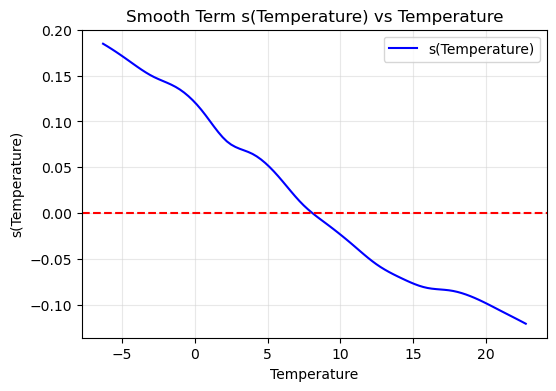

In [24]:
no_of_features = 1
linear_1 = LR_func(cluster_1_df)
gam_1 = gam_func(cluster_1_df)
s_temp_1 = smooth_term(cluster_1_df, gam_1)

Linear Regression Model
Mean Squared Error (MSE): 0.008986187184469387
Root Mean Squared Error (RMSE): 0.0948
Mean Absolute Error (MAE): 0.0683
R-squared (R²): 0.4631
GAM model with 1 features
Mean Squared Error (MSE): 0.008474866838857844
Root Mean Squared Error (RMSE): 0.0921
Mean Absolute Error (MAE): 0.0653
R-squared (R²): 0.4936


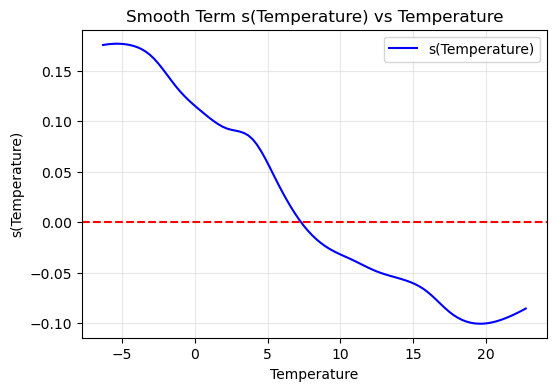

In [30]:
linear_2 = LR_func(cluster_2_df)
gam_2 = gam_func(cluster_2_df)
s_temp_2 = smooth_term(cluster_2_df, gam_2)

Linear Regression Model
Mean Squared Error (MSE): 0.014895630182447397
Root Mean Squared Error (RMSE): 0.1220
Mean Absolute Error (MAE): 0.0698
R-squared (R²): -0.1079
GAM model with 1 features
Mean Squared Error (MSE): 0.014397092186205596
Root Mean Squared Error (RMSE): 0.1200
Mean Absolute Error (MAE): 0.0676
R-squared (R²): -0.0708


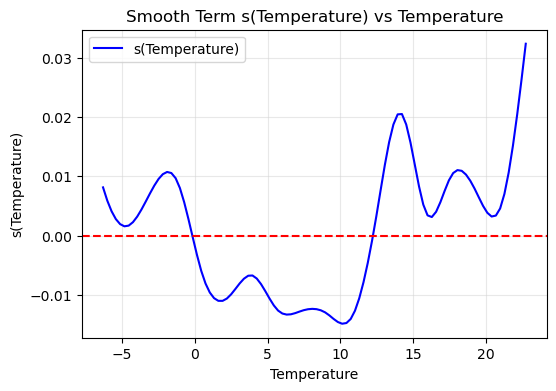

In [31]:
linear_3 = LR_func(cluster_3_df)
gam_3 = gam_func(cluster_3_df)
s_temp_3 = smooth_term(cluster_3_df, gam_3)

Linear Regression Model
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0000
Mean Absolute Error (MAE): 0.0000
R-squared (R²): 1.0000
did not converge
GAM model with 1 features
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0000
Mean Absolute Error (MAE): 0.0000
R-squared (R²): 1.0000


C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\pygam\pygam.py:806: RuntimeWarning: divide by zero encountered in scalar divide
  diff = np.linalg.norm(self.coef_ - coef_new) / np.linalg.norm(coef_new)
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\pygam\pygam.py:806: RuntimeWarning: invalid value encountered in scalar divide
  diff = np.linalg.norm(self.coef_ - coef_new) / np.linalg.norm(coef_new)
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2134: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\pygam\distributions.py:199: RuntimeWarning: invalid value encountered in divide
  dev /= self.scale
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\pygam\pygam.py:1292: RuntimeWarning: invalid value encountered in scalar divide
  score = score / rank


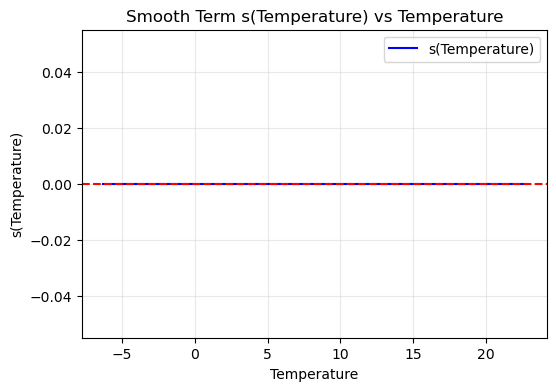

In [32]:
linear_4 = LR_func(cluster_4_df)
gam_4 = gam_func(cluster_4_df)
s_temp_4 = smooth_term(cluster_4_df, gam_4)

C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


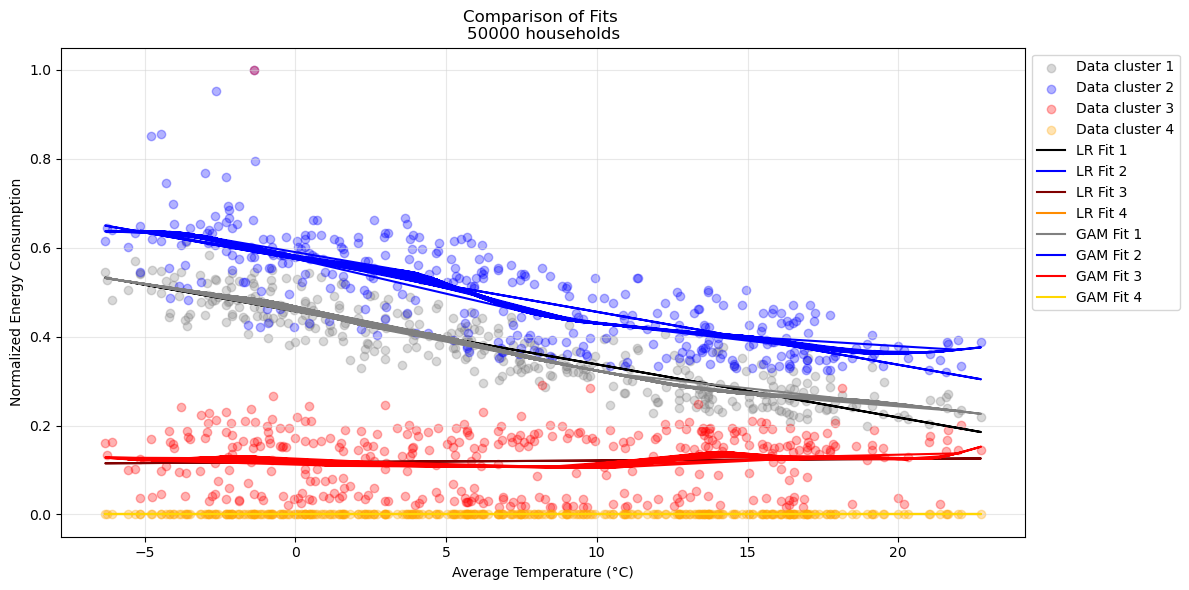

In [33]:
# Plot the data and model predictions
plt.figure(figsize=(12, 6))

# Scatter plot of the actual data

plt.scatter(cluster_1_df['avg_temperature'], cluster_1_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 1', color ='gray')
plt.scatter(cluster_2_df['avg_temperature'], cluster_2_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 2', color ='blue')
plt.scatter(cluster_3_df['avg_temperature'], cluster_3_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 3', color ='red')
plt.scatter(cluster_4_df['avg_temperature'], cluster_4_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 4', color ='orange')
#plt.scatter(daily_df['avg_temperature'], daily_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 3', color ='orange')
# Sorting by 'avg_temperature' for proper prediction plotting
if no_of_features == 2:
    # Sort by temperature and retain month for multiple predictors
    #sorted_df = daily_df.sort_values(by='avg_temperature')
    
    # Plot predictions from linear regression
    plt.plot(
        sorted_df['avg_temperature'], 
        linear_model.predict(sorted_df[['avg_temperature', 'month']]), 
        color='black', 
        label='Linear Regression Fit'
    )
    
    # Plot predictions from GAM model
    plt.plot(
        sorted_df['avg_temperature'], 
        gam.predict(sorted_df[['avg_temperature', 'month']]), 
        color='red', 
        label='GAM Fit'
    )

else:
    # Sort by temperature for single predictor
    #sorted_df = daily_df.sort_values(by='avg_temperature')
    
    # Plot predictions from linear regression
    plt.plot(
        cluster_1_df['avg_temperature'], 
        linear_1.predict(cluster_1_df[['avg_temperature']]), 
        color='black', 
        label='LR Fit 1'
    )
        # Plot predictions from linear regression
    plt.plot(
        cluster_2_df['avg_temperature'], 
        linear_2.predict(cluster_2_df[['avg_temperature']]), 
        color='blue', 
        label='LR Fit 2'
    )
    plt.plot(
        cluster_3_df['avg_temperature'], 
        linear_3.predict(cluster_3_df[['avg_temperature']]), 
        color='maroon', 
        label='LR Fit 3'
    )
        
    # Plot predictions from linear regression
    plt.plot(
        cluster_4_df['avg_temperature'], 
        linear_4.predict(cluster_4_df[['avg_temperature']]), 
        color='darkorange', 
        label='LR Fit 4'
    )
    
    # Plot predictions from GAM model
    plt.plot(
        cluster_1_df['avg_temperature'], 
        gam_1.predict(cluster_1_df[['avg_temperature']]), 
        color='gray', 
        label='GAM Fit 1'
    )
    
    # Plot predictions from GAM model
    plt.plot(
        cluster_2_df['avg_temperature'], 
        gam_2.predict(cluster_2_df[['avg_temperature']]), 
        color='blue', 
        label='GAM Fit 2'
    )
    # Plot predictions from GAM model
    plt.plot(
        cluster_3_df['avg_temperature'], 
        gam_3.predict(cluster_3_df[['avg_temperature']]), 
        color='red', 
        label='GAM Fit 3'
    )

    # Plot predictions from GAM model
    plt.plot(
        cluster_4_df['avg_temperature'], 
        gam_4.predict(cluster_4_df[['avg_temperature']]), 
        color="gold", 
        label='GAM Fit 4'
    )
# Adding labels, title, and grid
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Normalized Energy Consumption')
plt.title('Comparison of Fits \n50000 households')
#plt.ylim(0,2.25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.5, color='lightgray')
plt.savefig(f'comparison_{no_of_features}_feature_all_clusters_normalized_daily.png', bbox_inches='tight')
plt.tight_layout()
# Display the plot
plt.show()

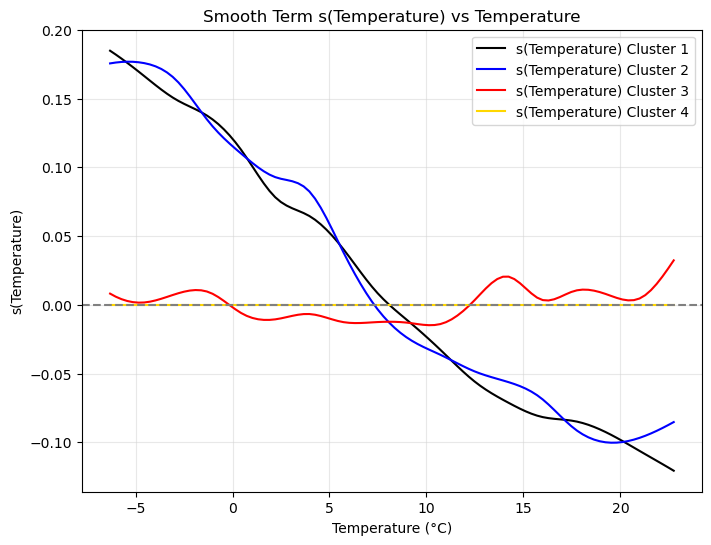

In [34]:
# Plot s(temperature) vs temperature
plt.figure(figsize=(8, 6))

#plt.subplot(1, 2, 1)
temperature_range = np.linspace(cluster_1_df['avg_temperature'].min(), cluster_1_df['avg_temperature'].max(), 100)
plt.plot(temperature_range, s_temp_1, label='s(Temperature) Cluster 1', color='black')
plt.plot(temperature_range, s_temp_2, label='s(Temperature) Cluster 2', color='blue')
plt.plot(temperature_range, s_temp_3, label='s(Temperature) Cluster 3', color='red')
plt.plot(temperature_range, s_temp_4, label='s(Temperature) Cluster 4', color='gold')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Temperature (°C)')
plt.ylabel('s(Temperature)')
plt.title('Smooth Term s(Temperature) vs Temperature')
plt.legend()
plt.grid(True, alpha= 0.5, color= 'lightgray')
plt.savefig(f'smooth_term_cluster_4_daily_normalized.png', bbox_inches='tight')